# Generate Storm Center coordinates graphs
This will use Laura as an example

In [13]:
from datetime import datetime
import pandas as pd
from glmtools.io.glm import GLMDataset
from glmtools.io.imagery import open_glm_time_series, aggregate
import os
import xarray as xr
from dateutil import parser
import numpy as np
import netCDF4 as nc
from  matplotlib.colors import LinearSegmentedColormap
# from mpl_toolkits.basemap import Basemap
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
import matplotlib as mpl         
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

In [5]:
# constants
track_file = "./Data/Laura/Hurricane_Laura_Trackfile_Spline.csv"
sample_glm_file = "./Data/GLM/2020/240/00/OR_GLM-L2-LCFA_G17_s20202400000400_e20202400001000_c20202400001014.nc"

In [7]:
df = pd.read_csv(track_file)
df

NameError: name 'pd' is not defined

In [4]:
df["Long"].to_numpy()

array([-25.4       , -25.44796431, -25.49592873, ..., -92.8425519 ,
       -92.82838332, -92.81419627])

In [5]:
print(parser.parse(df["Date"][0]))

2020-08-16 18:00:00


In [3]:
# from a single netcdf file return [date, groups_lat, groups_lon]
def reduce_file(data_file):
    
    data = GLMDataset(data_file).dataset
    # time data in format "YYYY-MM-DD HH:MM:SS"
    time_str = data.time_coverage_start[:-3].replace('T', ' ')
    
    # extract data about groups
    groups = data[['group_energy','group_area']]
    groups = groups.drop(['group_parent_flash_id','lightning_wavelength','product_time','group_time_threshold','flash_time_threshold','lat_field_of_view','lon_field_of_view'])
    
    # group lat, lon
    group_lon, group_lat = groups['group_lon'].values, groups['group_lat'].values
    
    date = parser.parse(time_str, "")
    return [date, group_lat, group_lon]

In [6]:
reduce_file(sample_glm_file)

NameError: name 'GLMDataset' is not defined

### Iterate through the track file

In [18]:
for index, row in df.iterrows():
    if index != 1551:
        continue
    date_str = row["Date"]
    print(index, date_str)
#     continue
    storm_center_lat = row["Lat"]
    storm_center_lon = row["Long"]
    print(index, date_str)
    
    # construct path to correct file
    # TODO: update year, check yday format 000 or 00
    # 
    date = parser.parse(date_str)
    yday = date.timetuple().tm_yday
    hour = date.timetuple().tm_hour
    year = date.timetuple().tm_year
    path = "./Data/GLM/{:d}/{:03d}/{:02d}/".format(year, yday, hour)
    print(path)
    
    group_lat = np.array([])
    group_lon = np.array([])
    
    if os.path.exists(path):
        print("Path exists")
        for f in sorted(os.listdir(path)):

            (time_stamp, lat, lon) = reduce_file("{}{}".format(path, f))

            group_lat = np.concatenate((group_lat, lat))
            group_lon = np.concatenate((group_lon, lon))
            time_diff = time_stamp - date
            print(time_diff)
            if time_diff.total_seconds() >= 10 * 60: # check if the time difference is greater than 10 mins or not
                break
        
    else:
        # run download script
        print("Path does not exist")
        None


1551 2020-08-27 12:30:00
1551 2020-08-27 12:30:00
./Data/GLM/2020/240/12/
Path exists
-1 day, 23:30:00
-1 day, 23:30:20
-1 day, 23:30:40
-1 day, 23:31:00
-1 day, 23:31:20
-1 day, 23:31:40
-1 day, 23:32:00
-1 day, 23:32:20
-1 day, 23:32:40
-1 day, 23:33:00
-1 day, 23:33:20
-1 day, 23:33:40
-1 day, 23:34:00
-1 day, 23:34:20
-1 day, 23:34:40
-1 day, 23:35:00
-1 day, 23:35:20
-1 day, 23:35:40
-1 day, 23:36:00
-1 day, 23:36:20
-1 day, 23:36:40
-1 day, 23:37:00
-1 day, 23:37:20
-1 day, 23:37:40
-1 day, 23:38:00
-1 day, 23:38:20
-1 day, 23:38:40
-1 day, 23:39:00
-1 day, 23:39:20
-1 day, 23:39:40
-1 day, 23:40:00
-1 day, 23:40:20
-1 day, 23:40:40
-1 day, 23:41:00
-1 day, 23:41:20
-1 day, 23:41:40
-1 day, 23:42:00
-1 day, 23:42:20
-1 day, 23:42:40
-1 day, 23:43:00
-1 day, 23:43:20
-1 day, 23:43:40
-1 day, 23:44:00
-1 day, 23:44:20
-1 day, 23:44:40
-1 day, 23:45:00
-1 day, 23:45:20
-1 day, 23:45:40
-1 day, 23:46:00
-1 day, 23:46:20
-1 day, 23:46:40
-1 day, 23:47:00
-1 day, 23:47:20
-1 day, 23:47

In [19]:
group_lon.shape

(68976,)

In [10]:
# convert lat, lon to storm center coordinates system
lon = group_lon - storm_center_lon
lat = group_lat - storm_center_lat

nearby_lon = []
nearby_lat = []
for lon, lat in zip(group_lon, group_lat):
    if abs(lon - storm_center_lon) > 6 or abs(lat - storm_center_lat) > 6:
        continue
    nearby_lon.append(lon)
    nearby_lat.append(lat)

nearby_lon = np.array(nearby_lon)
nearby_lat = np.array(nearby_lat)

extend = 
25.271435507015692 37.271435507015696
-99.22225972831109 -87.22225972831109
center =  -93.22225972831109 31.271435507015692


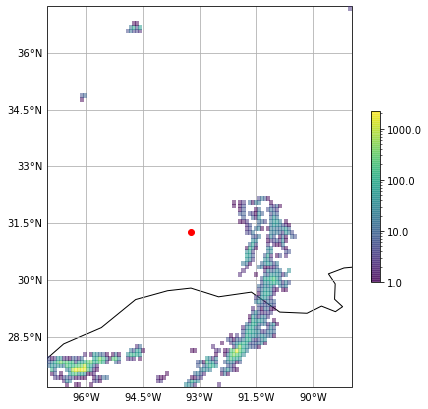

In [14]:
# determine the region of interest
# min_lat = min(nearby_lat)
# max_lat = max(nearby_lat)
# min_lon = min(nearby_lon)
# max_lon = max(nearby_lon)

min_lat = storm_center_lat - 6
max_lat = storm_center_lat + 6
min_lon = storm_center_lon - 6
max_lon = storm_center_lon + 6

print("extend = ")
print(min_lat, max_lat)
print(min_lon, max_lon)

plt.figure(figsize=(7, 7))
extent = [min_lon, max_lon, min_lat, max_lat]

ax2 = plt.axes(projection=ccrs.PlateCarree())
ax2.set_extent(extent, ccrs.PlateCarree())

xynps = ax2.projection.transform_points(ccrs.PlateCarree(), nearby_lat, nearby_lon)
# print(nearby_lat)
# print(xynps)
h = ax2.hist2d(nearby_lon, nearby_lat, bins=100, zorder=10, alpha=0.5, cmin = None, norm=mpl.colors.LogNorm())

ax2.coastlines(resolution='110m')
gl = ax2.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False

# center of storm
ax2.plot([storm_center_lon], [storm_center_lat],
         color='red', marker='o',
         transform=ccrs.PlateCarree(),
         )
print("center = ", storm_center_lon, storm_center_lat)
# color bar
cbar = plt.colorbar(h[3], ax=ax2, shrink=0.45, format='%.1f')  # h[3]: image

plt.show()

ValueError: autodetected range of [4142877.1661029384, inf] is not finite

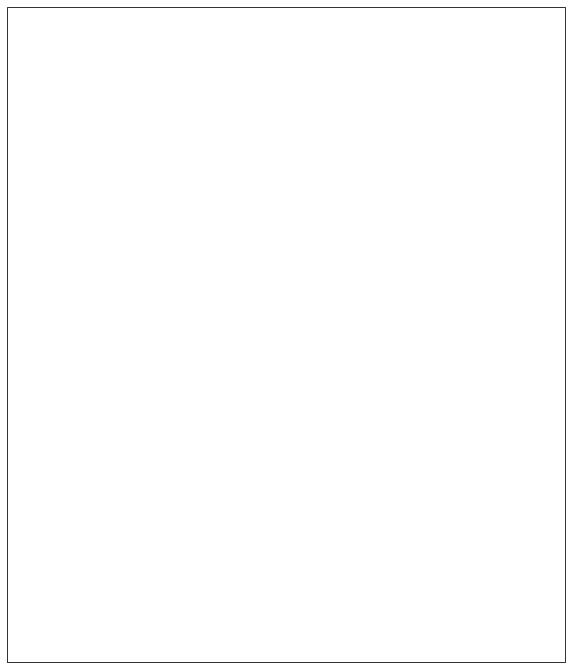

In [15]:
import numpy as np 
import matplotlib as mpl        
import matplotlib.pyplot as plt 
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

request = cimgt.OSM()
fig, ax = plt.subplots(figsize=(10,16),
                       subplot_kw=dict(projection=request.crs))
extent = [min_lon, max_lon, min_lat, max_lat]  # (xmin, xmax, ymin, ymax)
ax.set_extent(extent)
# ax.add_image(request, 8)

# generate (x, y) centering at (extent[0], extent[2])
# x = extent[0] + np.random.randn(1000)
# y = extent[2] + np.random.randn(1000)
# print(x[:10])
# print(y[:10])
# do coordinate conversion of (x,y)
xynps = ax.projection.transform_points(ccrs.Geodetic(), nearby_lat, nearby_lon)
# print(xynps[:10])
# make a 2D histogram
h = ax.hist2d(xynps[:,0], xynps[:,1], bins=90, zorder=10, alpha=0.5, cmin = 0.001, norm=mpl.colors.LogNorm())
# h[h==0] = np.nan
#h: (counts, xedges, yedges, image)

cbar = plt.colorbar(h[3], ax=ax, shrink=0.45, format='%.1f')  # h[3]: image

plt.show()

In [11]:
# convert to from degree to km
# https://stackoverflow.com/questions/1253499/simple-calculations-for-working-with-lat-lon-and-km-distance
dis_from_center_y = lat * 110.574
dis_from_center_x = lon * 111.320 * np.cos(np.radians(lat))

In [12]:
group_loc = []
a = np.random.random((41, 41))
for i in range(41):
    for j in range(41):
        a[i][j] = 0
#     print(a)

for x, y in zip(dis_from_center_x, dis_from_center_y):
    if abs(x) > 400 or abs(y) > 400:
        continue
    group_loc.append((x, y))
    j = int(x / 20 + 20)
    i = int(y / 20 + 20)
#     print(i, j)
    a[-(i+1)][j] += 1
a[20][20] = a.max()

In [13]:
len(group_loc)

23553

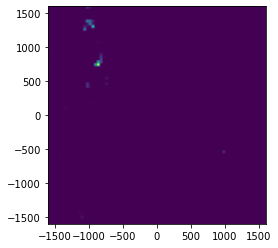

In [14]:
import numpy as np
import numpy.random
import matplotlib.pyplot as plt

# Generate some test data
x = np.random.randn(8873)
y = np.random.randn(8873)

heatmap, xedges, yedges = np.histogram2d(dis_from_center_y, dis_from_center_x, bins=80)
extent = [-1600, 1600, -1600, 1600]

plt.clf()
plt.imshow(heatmap, extent=extent, origin='lower')
plt.show()

In [15]:
a[a==0] = np.nan
a

array([[ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       ...,
       [ nan,  nan,  nan, ...,  nan,  nan,  nan],
       [475.,  89.,  22., ...,  nan,  nan,  nan],
       [306., 695., 798., ...,  nan,  nan,  nan]])

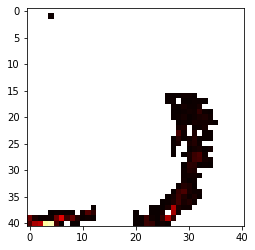

In [16]:
plt.imshow(a, cmap='hot', interpolation='nearest')
plt.show()

In [21]:
log_a

array([[       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [2.6766937 , 1.94939049, 1.34242465, ...,        nan,        nan,
               nan],
       [2.48572157, 2.84198487, 2.90200295, ...,        nan,        nan,
               nan]])

In [17]:
a
row_label = np.zeros(41)
col_label = np.zeros(41)
a
log_a = np.log10(a+0.0001)


In [26]:
def plot_heatmap(dis_from_center_x, dis_from_center_y, grid_size, km_per_cell):
    grid = np.zeros((grid_size, grid_size))
    
    min_x = -grid_size * km_per_cell // 2
    min_y = -grid_size * km_per_cell // 2
    max_x = -min_x
    max_y = -min_y
    
    print(min_x, min_y)
    
    for x, y in zip(dis_from_center_x, dis_from_center_y):
        if abs(x) > max_x or abs(y) > max_y:
            continue
        
        j = int((x - min_x) / km_per_cell)
        i = int((y - min_y) / km_per_cell)
    #     print(i, j)
        grid[-(i+1)][j] += 1
    grid = np.log10(grid + 0.000001)
    plt.imshow(log_a, cmap = 'hot', interpolation = 'none')

-810 -810


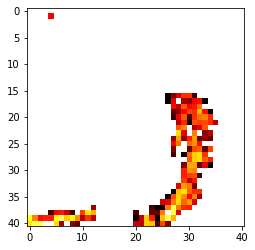

In [27]:
plot_heatmap(dis_from_center_x, dis_from_center_y, 81, 20)

TypeError: 'numpy.ndarray' object is not callable

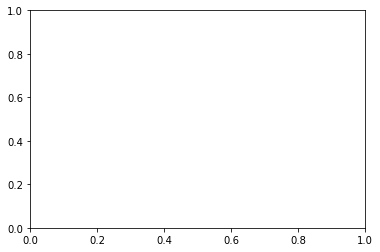

In [19]:
fig, ax = plt.subplots()
im, cbar = heatmap(log_a, row_label, col_label, ax=ax,
                   cmap="hot", cbarlabel="number of groups")
texts = annotate_heatmap(im, valfmt="")

fig.tight_layout()
plt.show()

In [21]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt


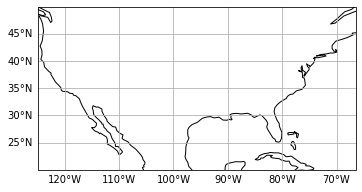

In [23]:
plt.figure(figsize=(7, 3))
ax2 = plt.axes(projection=ccrs.PlateCarree())
ax2.set_extent([, -66.5, 20, 50], ccrs.PlateCarree())

ax2.coastlines(resolution='110m')
gl = ax2.gridlines(draw_labels=True)
gl.top_labels = False
gl.right_labels = False
plt.show()

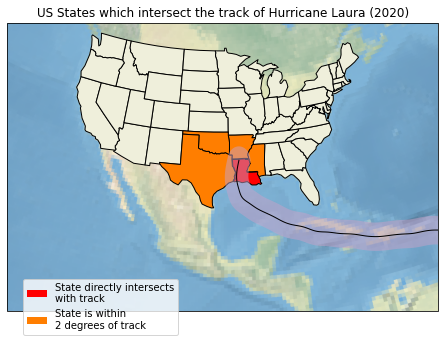

In [39]:
"""
Hurricane Katrina
-----------------
This example uses the power of Shapely to illustrate states that are likely to
have been significantly impacted by Hurricane Katrina.
"""
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import shapely.geometry as sgeom

import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader


def sample_data():
    """
    Return a list of latitudes and a list of longitudes (lons, lats)
    for Hurricane Katrina (2005).
    The data was originally sourced from the HURDAT2 dataset from AOML/NOAA:
    https://www.aoml.noaa.gov/hrd/hurdat/newhurdat-all.html on 14th Dec 2012.
    """
    lons = [-75.1, -75.7, -76.2, -76.5, -76.9, -77.7, -78.4, -79.0,
            -79.6, -80.1, -80.3, -81.3, -82.0, -82.6, -83.3, -84.0,
            -84.7, -85.3, -85.9, -86.7, -87.7, -88.6, -89.2, -89.6,
            -89.6, -89.6, -89.6, -89.6, -89.1, -88.6, -88.0, -87.0,
            -85.3, -82.9]

    lats = [23.1, 23.4, 23.8, 24.5, 25.4, 26.0, 26.1, 26.2, 26.2, 26.0,
            25.9, 25.4, 25.1, 24.9, 24.6, 24.4, 24.4, 24.5, 24.8, 25.2,
            25.7, 26.3, 27.2, 28.2, 29.3, 29.5, 30.2, 31.1, 32.6, 34.1,
            35.6, 37.0, 38.6, 40.1]

    return lons, lats


def main():
    fig = plt.figure()
    # to get the effect of having just the states without a map "background"
    # turn off the background patch and axes frame
    ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.LambertConformal(),
                      frameon=True)
    ax.patch.set_visible(False)

    ax.set_extent([-125, -66.5, 10, 50], ccrs.Geodetic())

    shapename = 'admin_1_states_provinces_lakes'
    states_shp = shpreader.natural_earth(resolution='110m',
                                         category='cultural', name=shapename)

    lons, lats = sample_data()
    lons = df["Long"].to_numpy()
    lats = df["Lat"].to_numpy()
    ax.set_title('US States which intersect the track of '
                 'Hurricane Laura (2020)')
    ax.stock_img()
    # turn the lons and lats into a shapely LineString
    track = sgeom.LineString(zip(lons, lats))

    # buffer the linestring by two degrees (note: this is a non-physical
    # distance)
    track_buffer = track.buffer(2)

    def colorize_state(geometry):
        facecolor = (0.9375, 0.9375, 0.8593750)
        if geometry.intersects(track):
            facecolor = 'red'
        elif geometry.intersects(track_buffer):
            facecolor = '#FF7E00'
        return {'facecolor': facecolor, 'edgecolor': 'black'}

    ax.add_geometries(
        shpreader.Reader(states_shp).geometries(),
        ccrs.PlateCarree(),
        styler=colorize_state)

    ax.add_geometries([track_buffer], ccrs.PlateCarree(),
                      facecolor='#C8A2C8', alpha=0.5)
    ax.add_geometries([track], ccrs.PlateCarree(),
                      facecolor='none', edgecolor='k')

    # make two proxy artists to add to a legend
    direct_hit = mpatches.Rectangle((0, 0), 1, 1, facecolor="red")
    within_2_deg = mpatches.Rectangle((0, 0), 1, 1, facecolor="#FF7E00")
    labels = ['State directly intersects\nwith track',
              'State is within \n2 degrees of track']
    ax.legend([direct_hit, within_2_deg], labels,
              loc='lower left', bbox_to_anchor=(0.025, -0.1), fancybox=True)

    plt.show()


if __name__ == '__main__':
    main()

-113.22225972831109
11.271435507015692
-73.22225972831109
51.271435507015696


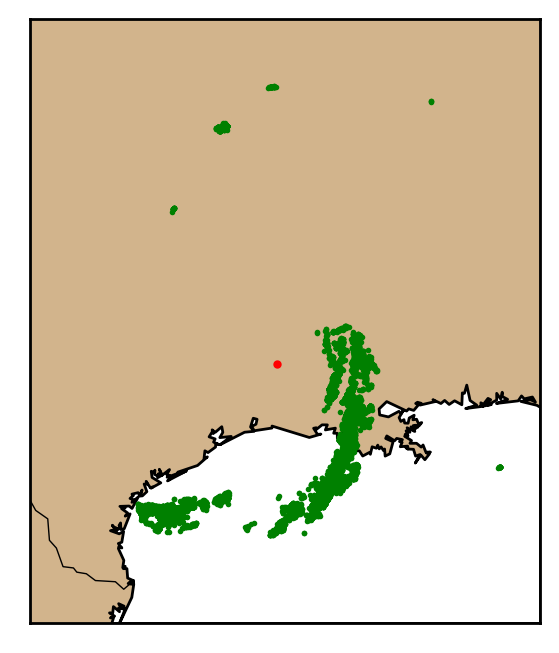

In [33]:
llcrnrlon = storm_center_lon - 20 # lower-left longitude
llcrnrlat = storm_center_lat - 20 # lower-left lattitude
urcrnrlon = storm_center_lon + 20 # upper-right longitude
urcrnrlat = storm_center_lat + 20 # upper-right lattitude
print(llcrnrlon)
print(llcrnrlat)
print(urcrnrlon)
print(urcrnrlat)
llcrnrlon = -100
llcrnrlat = 25
urcrnrlon = -86
urcrnrlat = 39

# draw the figure
fig = plt.figure(dpi=200)
m = Basemap(projection='merc', llcrnrlon=llcrnrlon, llcrnrlat=llcrnrlat,
            urcrnrlon=urcrnrlon,urcrnrlat=urcrnrlat,
            lon_0=0,lat_0=0, resolution='l')

m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color = 'tan')
m.drawmapboundary()

group_x, group_y = m(group_lon, group_lat)
m.plot(group_x, group_y, 'go', markersize=1)

storm_center_x, storm_center_y = m(storm_center_lon, storm_center_lat)
m.plot(storm_center_x, storm_center_y, 'ro', markersize=2)

In [150]:
vegetables = ["cucumber", "tomato", "lettuce", "asparagus",
              "potato", "wheat", "barley"]
farmers = ["Farmer Joe", "Upland Bros.", "Smith Gardening",
           "Agrifun", "Organiculture", "BioGoods Ltd.", "Cornylee Corp."]

harvest = np.array([[0.8, 2.4, 2.5, 3.9, 0.0, 4.0, 0.0],
                    [2.4, 0.0, 4.0, 1.0, 2.7, 0.0, 0.0],
                    [1.1, 2.4, 0.8, 4.3, 1.9, 4.4, 0.0],
                    [0.6, 0.0, 0.3, 0.0, 3.1, 0.0, 0.0],
                    [0.7, 1.7, 0.6, 2.6, 2.2, 6.2, 0.0],
                    [1.3, 1.2, 0.0, 0.0, 0.0, 3.2, 5.1],
                    [0.1, 2.0, 0.0, 1.4, 0.0, 1.9, 6.3]])

TypeError: unhashable type: 'slice'

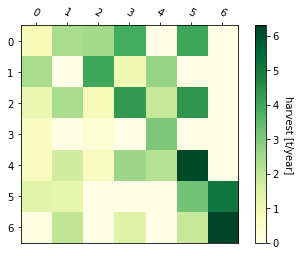

In [154]:
fig, ax = plt.subplots()

im, cbar = heatmap(harvest, vegetables, farmers, ax=ax,
                   cmap="YlGn", cbarlabel="harvest [t/year]")
texts = annotate_heatmap(im, valfmt="{x:.1f} t")

fig.tight_layout()
plt.show()

In [17]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts